# COGS 108 - Electric Vehicles and Electricity Prices

### Video Report - https://drive.google.com/file/d/10VexNr8x5wrzDQiMaTRhzvTGV6PtksDp/view?usp=sharing

## Permissions

- [X] YES - make available
- [ ] NO - keep private

# Overview

With the recent push for more sustainable and eco-friendly modes of transportation, the purpose of this study is to explore whether there is a positive correlation between the increasing presence of electric vehicles and the price of electricity in the U.S. To answer this question, our team gathered datasets of electric vehicle sales and charging stations to measure electric vehicle presence. After cleaning and exploring the data, we conducted OLS regression analysis on several variables to determine their impact on the national electricity price. Overall, we concluded that electric vehicle sales, charging stations, and port stations do have a moderate positive correlation with the electricity price; however, this is likely due to coinciding trends over time rather than direct influence, and causality cannot be proved.

# Names

- Soyon Kim
- Lucy Gai
- Jenna Yang
- Ann Chwu
- Darian Hong

<a id='research_question'></a>
# Research Question

Is there a positive correlation between the increasing presence of electric vehicles in the United States and the price of electricity nationwide? Electric vehicle presence is defined with the number of plug-in electric vehicles (PEVs) sold and number of charging stations built in the US. Electricity prices are defined through residential, commercial, and industrial prices in cents/kWh.

## Background and Prior Work

Electric vehicles (EV) relying on electric motors more than any other energy source are rapidly becoming the future of ubiquitous technology. Electric transportation advocates argue that the transition can lend a solution to climate change, introduce a new job market, and provide an alternate option for already expensive, traditional cars. Along with Tesla, more companies like Uber, Lucid Motors, and Volta Charging are joining the trend of EV’s. 

As data has shown, the U.S. electric vehicle market has grown from just a few thousand vehicles in 2010 to more than 300,000 sold annually in 2020 (2). A UC Berkeley study on electric vehicles questions how EV adapation and sales will impact factors such as employment, healthcare costs, and greenhouse gas emissions (3). In particular, it analyses consumer adoption trends and patterns for EV sales and then applies potential macroeconomic impacts this may have. Yet with the growth of EVs and their integration into society, there must also be assessments and modifications to U.S. electric power generation and distribution systems. A Department of Energy summary report on EVs discusses the quick expansion of EVs and questions the ability of U.S. energy generation, as well as generation capacity in future years to come (4). These concerns on additional electricity consumption and growing demand has led us to also question how the rise in EVs will affect electricity prices across the country. 

References (include links):
- 1) https://energynews.us/2022/01/28/transition-to-electric-transportation-must-elevate-equity-beyond-evs-advocates-say/ 
- 2) https://theicct.org/publication/evaluating-electric-vehicle-market-growth-across-u-s-cities/
- 3) http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.1048.8973&rep=rep1&type=pdf
- 4) https://www.energy.gov/sites/prod/files/2019/12/f69/GITT%20ISATT%20EVs%20at%20Scale%20Grid%20Summary%20Report%20FINAL%20Nov2019.pdf

# Hypothesis


We hypothesize that the more EV’s there are on the roads nationwide, the more electricity prices will increase across the entire nation of the U.S. The increased use of EVs would likely promote the growth of the electric power industry as they must accomodate for higher demands regarding electric power generation and usage, thus increasing price.

# Dataset(s)

Sales to Ultimate Customers (Megawatt Hours) by State by Sector by Provider, 1990-2020
- https://www.eia.gov/electricity/data.php > Sales > Monthly Form EIA-861M (formerly EIA-826) detailed data (1990 - present) > sales_revenue.xlsx
- 19485 observations
- This dataset contains monthly and yearly electricity sales in the US both nationally and by state, containing information from 1990 to the present. The sales are broken down into different categories: residential, commercial, industrial, transportation, other, and total. We want to use this data to analyze electricity prices and see how trends in prices (measured in cents/kWh) within each category compare to trends in electric vehicle and charging station data.

US Plug-In Electric Vehicle Sales by Model
- https://afdc.energy.gov/data/10567
- 55 observations
- This dataset contains the number of total sales of electric vehicles in the U.S from 2011 to 2018, broken down by the vehicle model. We would like to use this dataset to measure/estimate the number of EVs that were sold per year and compare the different years.

U.S. Public and Private Electric Vehicle Charging Infrastructure
- https://afdc.energy.gov/data/10964 
- 11 observations
- This dataset contains the number of electric vehicle supply equipment (EVSE) ports and the number of EV charging station locations in the US from 2011 to 2021. We want to use this dataset to compare the change in number over time, as well as combine the information with the EV sales to define electric vehicle presence.

# Setup

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import statsmodels.api as sm

# Data Cleaning

The data was not very clean as we had to change the type of the values often and had quite a bit of invalid entries to replace. To get the data into a usable format, we had to convert the numbers from strings into integers, convert all letters to lowercase and remove commas, and replace empty data with 0. We removed unnecessary columns and renamed necessary columns with more meaningful labels. For example, we renamed “Unnamed: 0_level_0” to “Year”. Finally, we manipulated certain data to also include the yearly percent change of certain column values (electricity price, EV sales, port and station counts) to account for autocorrelation when analyzing our data.

## Electric Vehicle Sales by Model Dataset

The EV Sales by Model dataset gives US sales of EVs by model, from 2011 to 2018. After converting the excel sheet to csv, we made sure to standardize the data by changing all number inputs from strings into integers, and then made sure there were no null or missing values in the dataset. We then chose to include only the totals for each year, summing up the counts for all model types and reindexing our dataframe to include only totals for each year as a column. Finally, we calculated the percent change for each year and added this as a column.

In [83]:
ev_sales = pd.read_csv("ev_sales.csv")
ev_sales.head()

,Vehicle,Type,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Chevy Volt,PHEV,"7,671","23,461","23,094","18,805","15,393","24,739","20,349","18,306","4,915"
1,Nissan Leaf,EV,"9,674","9,819","22,610","30,200","17,269","14,006","11,230","14,715","12,365"
2,Smart ED,EV,342,139,923,"2,594","1,387",657,544,"1,219",680
3,Mitsubishi I EV,EV,76,588,"1,029",196,115,94,6,-,-
4,BMW Active E,EV,-,673,-,-,-,-,-,-,-


In [84]:
# Function to standardize in ev_sales to be integers
def standardize_value(str_in):
    try:
        str_in = str_in.lower()
        str_in = str_in.strip()
        str_in = str_in.replace(",", "")
        
        if "-" in str_in:
            output = 0
        else:
            output = int(str_in)
        
    except:
        output = 0
            
    return output

In [85]:
# Apply the standardizing function to columns with numbers
for column in ev_sales.columns[2:]:
    ev_sales[column] = ev_sales[column].apply(standardize_value)

In [86]:
# Pivot table 
ev_sales = pd.melt(ev_sales, id_vars=['Vehicle'], value_vars=['2011', '2012', '2013','2014','2015', '2016', '2017', '2018','2019'],
        var_name='Year', value_name='Sales')

# Get only years
ev_sales = ev_sales.groupby('Year').sum().reset_index()

# Add percent change column
ev_sales['% Change Sales'] = ev_sales['Sales'].pct_change().fillna(0)*100

ev_sales["Year"] = ev_sales["Year"].apply(standardize_value)


In [87]:
ev_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Year            9 non-null      int64  
 1   Sales           9 non-null      int64  
 2   % Change Sales  9 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 344.0 bytes


In [88]:
ev_sales.head()

,Year,Sales,% Change Sales
0,2011,17763,0.000000
1,2012,53171,199.335698
2,2013,97102,82.622106
3,2014,118882,22.430022
4,2015,114023,-4.087246


## Public and Private Electric Vehicle Charging Infrastructure Dataset

The EV Charging Infrastructure Dataset gives the count of EVSE Ports and charging stations in the US from 2011 to 2021. After converting the original excel sheet to csv format, we again made sure to standardize the data by changing all number inputs from strings into integers, and then made sure there were no null or missing values in the dataset. Finally, we again calculated the yearly percent change for our column values of interest - EVSE Ports and Station Locations - and added columns in our dataframe to record this.

In [89]:
evse = pd.read_csv("evse_raw.csv")
evse

,Year,EVSE Ports,Station Locations
0,2011,"5,070","2,100"
1,2012,"14,982","6,200"
2,2013,"19,472","8,100"
3,2014,"25,602","10,712"
4,2015,"34,151","13,696"
5,2016,"45,124","17,723"
6,2017,"53,117","19,792"
7,2018,"64,037","22,826"
8,2019,"85,079","26,959"
9,2020,"106,814","31,738"


In [90]:
# Apply the standardizing function to columns with numbers
for column in evse.columns[1:]:
    evse[column] = evse[column].apply(standardize_value)

In [91]:
# Add percent change columns
evse['% Change Ports'] = evse['EVSE Ports'].pct_change().fillna(0)*100
evse['% Change Stations'] = evse['Station Locations'].pct_change().fillna(0)*100

In [92]:
evse.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               11 non-null     int64  
 1   EVSE Ports         11 non-null     int64  
 2   Station Locations  11 non-null     int64  
 3   % Change Ports     11 non-null     float64
 4   % Change Stations  11 non-null     float64
dtypes: float64(2), int64(3)
memory usage: 568.0 bytes


In [93]:
evse

,Year,EVSE Ports,Station Locations,% Change Ports,% Change Stations
0,2011,5070,2100,0.000000,0.000000
1,2012,14982,6200,195.502959,195.238095
2,2013,19472,8100,29.969296,30.645161
3,2014,25602,10712,31.481101,32.246914
4,2015,34151,13696,33.391923,27.856609
5,2016,45124,17723,32.130831,29.402745
6,2017,53117,19792,17.713412,11.674096
7,2018,64037,22826,20.558390,15.329426
8,2019,85079,26959,32.859128,18.106545
9,2020,106814,31738,25.546845,17.726919


## Sales Revenue (Electricity)

This dataset contains monthly and yearly electricity sales in the US both nationally and by state, containing information from 1990 to the present. We extracted the sheet US-YTD from the original excel file and converted it to CSV. This portion of the data contained information on national revenue, sales, customers, and electricity prices from 1990 to 2021 in residential, commercial, industrial, transportation, and other categories with row observations broken down into months. After importing the csv file, we had to fix the column names due to the multi-index nature of the original data which generated various "unnamed" columns in our generated dataframe. We also removed revenue, sales, and customers columns since we wish to focus on electricity prices over time. We then extracted only the mean prices from the years and removed the individual monthly observations since we wish to focus on change over the years. Finally, we calculated the yearly percent change in price and added this as another column for analysis.

In [94]:
rev_sales = pd.read_csv("sales_revenue_raw.csv")
rev_sales

,Unnamed: 0,Unnamed: 1,Unnamed: 2,RESIDENTIAL,Unnamed: 4,Unnamed: 5,Unnamed: 6,COMMERCIAL,Unnamed: 8,Unnamed: 9,...,Unnamed: 17,Unnamed: 18,OTHER,Unnamed: 20,Unnamed: 21,Unnamed: 22,TOTAL,Unnamed: 24,Unnamed: 25,Unnamed: 26
0,NaN,NaN,NaN,Revenue,Sales,Customers,Price,Revenue,Sales,Customers,...,Customers,Price,Revenue,Sales,Customers,Price,Revenue,Sales,Customers,Price
1,1990.0,1,Final,"6,841,300","95,420,231",.,7.17,"4,332,195","62,498,967",.,...,.,.,"465,357","7,767,762",.,5.99,"15,091,189","240,874,655",.,6.27
2,1990.0,2,Final,"5,571,807","74,498,370",.,7.48,"4,070,345","56,912,068",.,...,.,.,"451,273","7,345,620",.,6.14,"13,514,792","213,362,594",.,6.33
3,1990.0,3,Final,"5,442,934","71,901,767",.,7.57,"4,191,027","57,979,978",.,...,.,.,"458,404","7,343,455",.,6.24,"13,626,535","214,067,173",.,6.37
4,1990.0,4,Final,"5,015,134","65,190,618",.,7.69,"4,065,960","56,480,718",.,...,.,.,"468,345","7,162,259",.,6.54,"13,022,717","205,071,739",.,6.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,2021.0,8,Preliminary,"22,168,583","158,634,041","138,446,332",13.97,"15,208,067","130,996,981","19,116,117",...,81,10.19,.,.,.,.,"44,329,583","380,365,775","158,606,056",11.65
412,2021.0,9,Preliminary,"18,706,730","131,847,798","138,486,142",14.19,"13,965,865","118,792,029","19,123,936",...,81,11.23,.,.,.,.,"39,270,194","336,002,774","158,650,411",11.69
413,2021.0,10,Preliminary,"14,713,464","104,293,368","137,835,330",14.11,"12,944,769","111,985,138","19,092,557",...,81,10.29,.,.,.,.,"34,042,374","300,837,900","157,950,655",11.32
414,2021.0,11,Preliminary,"14,249,501","100,937,877","137,344,547",14.12,"11,693,799","103,192,396","18,999,278",...,81,10.48,.,.,.,.,"32,081,295","286,143,610","157,366,909",11.21


In [95]:
# Remove unnecessary columns
rev_sales = rev_sales.drop(rev_sales.columns[2:26], axis=1)

# Fix column names
rev_sales.columns = ["Year", "Month", "Price"]

# Remove first row
rev_sales = rev_sales.drop(0)

# Reset index
rev_sales = rev_sales.reset_index(drop=True)

rev_sales

,Year,Month,Price
0,1990.0,1,6.27
1,1990.0,2,6.33
2,1990.0,3,6.37
3,1990.0,4,6.35
4,1990.0,5,6.46
...,...,...,...
410,2021.0,8,11.65
411,2021.0,9,11.69
412,2021.0,10,11.32
413,2021.0,11,11.21


In [96]:
# Find the annual values
rev_sales = rev_sales.loc[rev_sales["Month"] == "."]

# Find the year range we want
rev_sales = rev_sales.loc[rev_sales["Year"] > 2010]
rev_sales = rev_sales.loc[rev_sales["Year"] < 2020]

# Remove Month column as it's no longer needed
rev_sales = rev_sales.drop(columns="Month")

# Set the Price column to be float values
rev_sales["Price"] = rev_sales["Price"].apply(float)

# Set the Year column to be int values
rev_sales["Year"] = rev_sales["Year"].apply(int)

rev_sales = rev_sales.reset_index(drop=True)
rev_sales

,Year,Price
0,2011,9.90
1,2012,9.84
2,2013,10.07
3,2014,10.44
4,2015,10.41
5,2016,10.27
6,2017,10.48
7,2018,10.53
8,2019,10.54


In [97]:
# Add percent change column
rev_sales['% Change Price'] = rev_sales['Price'].pct_change().fillna(0)*100

rev_sales

,Year,Price,% Change Price
0,2011,9.90,0.000000
1,2012,9.84,-0.606061
2,2013,10.07,2.337398
3,2014,10.44,3.674280
4,2015,10.41,-0.287356
5,2016,10.27,-1.344861
6,2017,10.48,2.044791
7,2018,10.53,0.477099
8,2019,10.54,0.094967


All three datasets are now clean - all numerical values have been converted from strings and standardized, in addition to no null or missing data present. In addition, all three datasets are tidy as well - in each dataframe we have each variable as a column, each observation as a row, and each type of observational unit in a table. We have also removed columns we do not wish to focus on for analysis, and added many columns calculating percent change of variables, which we would like to use for our analysis.

# Data Analysis & Results (EDA)

### 1. Electric Vehicle Sales by Model Dataset

Text(0.5, 0, '% Change in Sales')

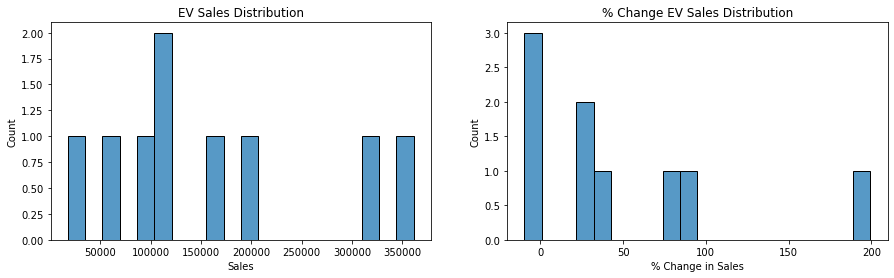

In [98]:
# observe EV sales distributions
fig, (ax1,ax2) = plt.subplots(figsize=(15, 4), ncols = 2)
sns.histplot(ev_sales['Sales'], bins=20, ax=ax1)
ax1.set_title('EV Sales Distribution')
ax1.set_xlabel('Sales')
sns.histplot(ev_sales['% Change Sales'], bins=20, ax=ax2)
ax2.set_title('% Change EV Sales Distribution')
ax2.set_xlabel('% Change in Sales')

Observing the distributions for electric vehicle sales, we see that the raw sales count maintains a relatively uniform distrubition with no count exceeding particularly high (the data hovers between 1 and 2 counts based on the number of bins we have chosen). The percent change in EV sales, however, shows a distribution that appears somewhat right skewed, particularly due to the outlier from 2012 (seen below again) with a 200% increase in sales. 

C:\Users\Lucy\AppData\Local\Temp/ipykernel_17304/4087522787.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


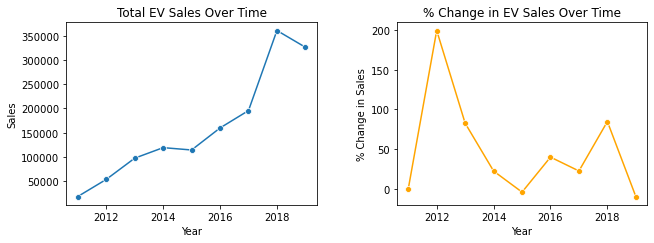

In [99]:
# side by side line plots of EV sales over time and % change in EV Sales over time
fig, ax = plt.subplots(1,2, figsize=(10,4.3))
sns.lineplot(x = ev_sales['Year'], y = ev_sales['Sales'], marker='o', ax=ax[0])
ax[0].set_title('Total EV Sales Over Time')
sns.lineplot(x = ev_sales['Year'], y = ev_sales['% Change Sales'], marker='o', color='orange', ax=ax[1])
ax[1].set_title('% Change in EV Sales Over Time')
ax[1].set_ylabel('% Change in Sales')
fig.tight_layout(pad=4.0)
fig.show()

In general, there is a clear positive trend in total EV sales over time minus the dip in 2019. However, looking at the % change we see for the most part a large spike in 2012, noting this as a clear outlier that marks the start of the sudden popularity in electric vehicles. Percent change generally increases from 2015 to 2018 and then suddenly dips in 2019.

Text(0.5, 1.0, '% Change in EV Sales Over Time')

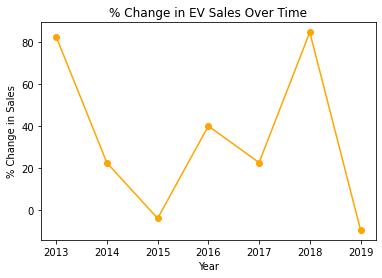

In [100]:
# % change in EV sales over time, but omitting the first two years due to being outliers
x = ev_sales['Year']
y = ev_sales['% Change Sales']
plt.plot(x.iloc[2:], y.iloc[2:], marker='o', color='orange')
plt.xlabel('Year')
plt.ylabel('% Change in Sales')
plt.title("% Change in EV Sales Over Time")

Considering the first two years marks the start of EV popularity and present themselves as outliers, we choose to remove them and look more closely at the remaining years. We note that there is quite a spike in 2018 despite following a dip in 2017. In addition, the graph presents more clearly that the drop from 2018 to 2019 is quite significant, leading to an all time low. The negative value indicates that EV sales had actually slowed down for the first time in nearly a decade.

### 2. Public and Private Electric Vehicle Charging Infrastructure Dataset

Text(0.5, 0, '% Change in Stations')

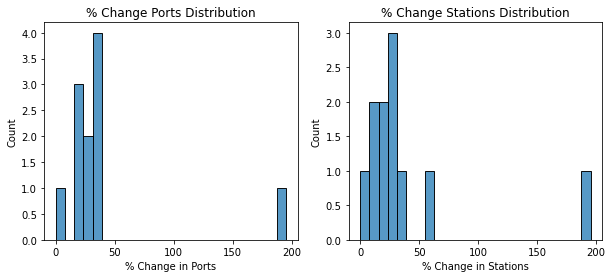

In [101]:
# observe distributions of port and stations changes
fig, (ax1,ax2) = plt.subplots(figsize=(10, 4), ncols = 2)
sns.histplot(evse['% Change Ports'], bins=25, ax=ax1)
ax1.set_title('% Change Ports Distribution')
ax1.set_xlabel('% Change in Ports')
sns.histplot(evse['% Change Stations'], bins=25, ax=ax2)
ax2.set_title('% Change Stations Distribution')
ax2.set_xlabel('% Change in Stations')

Examining the port and station distributions, we see again the outlier from 2012 nearing a 200% change from the previous year in both distributions, giving off a long right tail and leading to a right-skew. Ignoring this, the stations distribution shows a more clear normal distribution while ports is somewhat more vague.

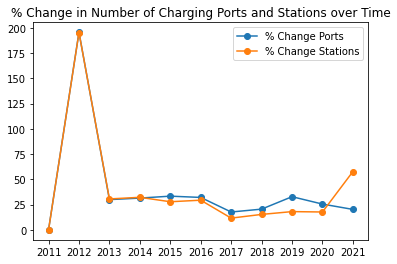

In [102]:
# line graph of % change of EVSE charging ports and charging stations over time
X = evse['Year']
plt.plot(X, evse['% Change Ports'], '-o', label = "% Change Ports")
plt.plot(X, evse['% Change Stations'], '-o', label = "% Change Stations")
plt.legend()
plt.xticks(X)
plt.title("% Change in Number of Charging Ports and Stations over Time")
plt.show()

In 2011, there is no change in percentage because it is the starting point for our data. From 2011 to 2012 we see a large spike in the % change in numbers of both charging ports and stations, which we can likely attribute to a rising popularity of electric vehicles. After 2012, the growth % compared to the previous year of the number of charging ports and stations appears to be more consistent, with a dip in recent years.

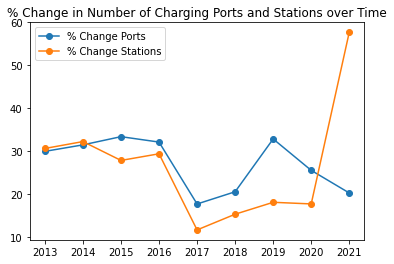

In [103]:
# the same graph as before, but omitting the first two years due to being outliers
X = evse['Year'].iloc[2:]
plt.plot(X, evse['% Change Ports'].iloc[2:], '-o', label = "% Change Ports")
plt.plot(X, evse['% Change Stations'].iloc[2:], '-o', label = "% Change Stations")
plt.legend()
plt.xticks(X)
plt.title("% Change in Number of Charging Ports and Stations over Time")
plt.show()

If we omit the first two years due to being outliers, we can have a better visualization of the remaining years. While the trends for both follow a similar pattern of a slight dip in 2017, recovery up to 2019, and then another dip going into 2020, last year there was an unexpected jump in the % change of charging stations.

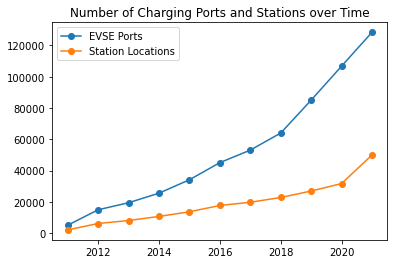

In [104]:
# line graph of the number of EVSE charging ports and charging stations over time
X = evse['Year']
plt.plot(X, evse['EVSE Ports'], '-o', label = "EVSE Ports")
plt.plot(X, evse['Station Locations'], '-o', label = "Station Locations")
plt.legend()
plt.title("Number of Charging Ports and Stations over Time")
plt.show()

Here we plotted the number of EVSE ports and EV charging station locations over the years to compare their respective growth. The number of EVSE ports consistently outnumbers that of charging station locations, and appears to be increasing at a larger rate each year as well. The number of EVSE ports takes on a more quadratic shape, while that of the station locations is mostly linear, excluding the last data point. This suggests either a potential exponential or linear growth of electric vehicle presence over time.

### 3. Sales Revenue (Electricity)

<AxesSubplot:xlabel='% Change Price', ylabel='Count'>

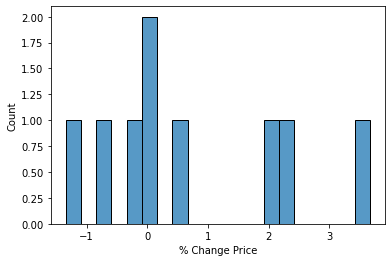

In [105]:
# observe distributions of electricity prices
sns.histplot(rev_sales['% Change Price'], bins=20)

Observing the distribution for the changes in electricity price, we see that it is relatively uniform with not much difference in the counts based on the number of bins we have selected. The most common changes in electricity price are quite close to 0% change or no change at all, somewhat close to the center of the distribution.

Text(0.5, 1.0, 'Electricity Price Over Time')

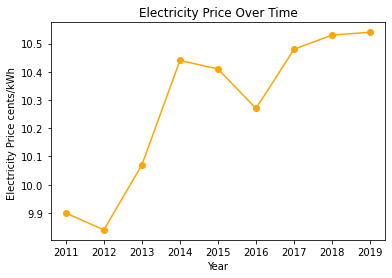

In [106]:
# electricity price over time
x = rev_sales['Year']
y = rev_sales['Price']
plt.plot(x, y, marker='o', color='orange')
plt.xlabel('Year')
plt.ylabel('Electricity Price cents/kWh ')
plt.title("Electricity Price Over Time")

C:\Users\Lucy\AppData\Local\Temp/ipykernel_17304/2790996464.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


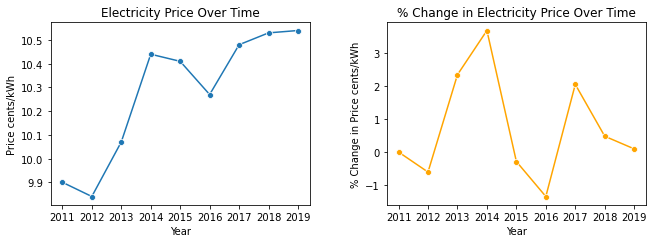

In [107]:
# side by side line plots of EV sales over time and % change in EV Sales over time
fig, ax =plt.subplots(1,2, figsize=(10,4.3))
sns.lineplot(x = rev_sales['Year'], y = rev_sales['Price'], marker='o', ax=ax[0])
ax[0].set_title('Electricity Price Over Time')
ax[0].set_ylabel('Price cents/kWh')
ax[0].set_xticks([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])
sns.lineplot(x = rev_sales['Year'], y = rev_sales['% Change Price'], marker='o', color='orange', ax=ax[1])
ax[1].set_title('% Change in Electricity Price Over Time')
ax[1].set_ylabel('% Change in Price cents/kWh')
ax[1].set_xticks([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])
fig.tight_layout(pad=4.0)
fig.show()

We can see here that while there is a general positive trend in electricity price over time, it is difficult to see a clear trend after accounting for autocorrelation and looking at the percent change over time. In both cases, 2012 and 2016 show dips in the plots. Looking at the percent change, 2016 hits an all time low with a negative percent change, following the peak in 2014. Overall, the percent change in price sees quite a variation over time.

### Price vs. Sales

[Text(0.5, 1.0, 'Electricity Prices (cents/kWh) vs EV Sales')]

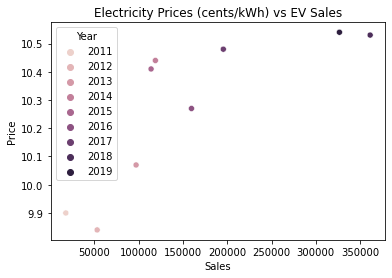

In [108]:
# scatterplot of changes in electricity prices (cents/kWh) for each year vs changes in electric vehicle sales
sns.scatterplot(x = ev_sales['Sales'],
                y = rev_sales['Price'],
                hue = rev_sales['Year'],
                legend = 'full').set(title = 'Electricity Prices (cents/kWh) vs EV Sales')

Here we made a scatterplot comparing EV sales and electricity prices (cents/kWh), with the color of each point referencing what year the data was from. Although there are not too many data points, they loosely form the shape of a square root graph, where EV sales and prices increased dramatically in earlier years, but have increased at a slowing rate in more recent ones. There is a noticeable positive relationship between the two.

### Price vs. Charging Ports

[Text(0.5, 1.0, 'Change in Electricity Price vs Change in Charging Ports')]

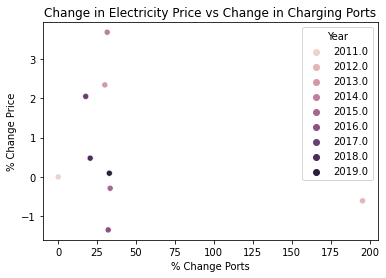

In [109]:
# scatterplot of changes in electricity prices (cents/kWh) for each year vs changes in charging ports
sns.scatterplot(x=evse["% Change Ports"],
                y=rev_sales["% Change Price"],
                hue=rev_sales["Year"],
                legend="full").set(title="Change in Electricity Price vs Change in Charging Ports")

Here we made a scatterplot graph looking at the relationship between the change in charging ports against the change in electricity price. By looking at the graph, we notice that the trend is quite vertical with a lot of variance in the values, suggesting that there isn't a noticeable relationship between them as we can't see a positive or negative trend. However, the year 2012 is an outlier that could skew the data towards the right.

### Price vs. Charging Stations

[Text(0.5, 1.0, 'Change in Electricity Price vs. Change in Charging Stations')]

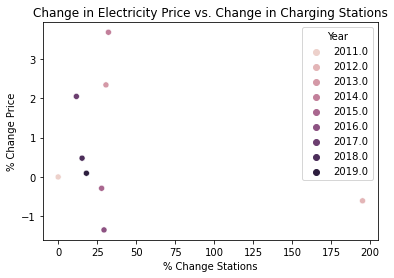

In [110]:
# scatterplot of changes in electricity prices (cents/kWh) for each year vs changes in charging stations
sns.scatterplot(x=evse["% Change Stations"],
                y=rev_sales["% Change Price"],
                hue = rev_sales["Year"],
                legend="full").set(title="Change in Electricity Price vs. Change in Charging Stations")

Here we made a scatter plot graph looking at the relationship between the change in charging stations against the change in electricity price. Similarly to the previous graph, we notice another vertical trend with a lot of variance so we can conclude that there isn't much of a relationship between the two variables. And once again, the data from 2012 presents itself as an extreme outlier that could skew our data to the right.

### All Trends Over Time

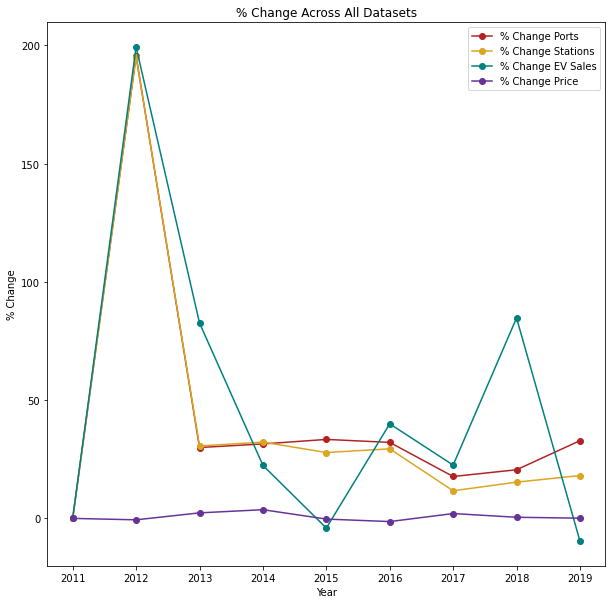

In [111]:
# visualize all percent changes over time
X = rev_sales['Year']
plt.figure(figsize=(10, 10))
plt.plot(X, evse['% Change Ports'].iloc[:-2], '-o', label = "% Change Ports", color = "firebrick")
plt.plot(X, evse['% Change Stations'].iloc[:-2], '-o', label = "% Change Stations", color = "goldenrod")
plt.plot(X, ev_sales['% Change Sales'], '-o', label = "% Change EV Sales", color = "teal")
plt.plot(X, rev_sales['% Change Price'], '-o', label = "% Change Price", color = "rebeccapurple")
plt.legend()
plt.xticks(X)
plt.xlabel('Year')
plt.ylabel('% Change')
plt.title("% Change Across All Datasets")
plt.show()

By comparing the % change across all three datasets, we can see that there is generally a steady trend between changes in charging stations, charging ports, and price of electricity between 2013 and 2019. This may suggest a positive correlation between electricity prices and electric vehicle presence. However, the change in EV sales varies much more in comparison, which makes it difficult to predict whether they truly have an effect. There is also similar trends to note among changes in EV sales and changes in charging stations, which spike early on and then decrease.

## Further Analysis

### Regression on EV Sales and Electricity Price

In [112]:
# merge dataframes for analysis
combined_df = pd.merge(ev_sales, evse, how="left")
combined_df = pd.merge(combined_df, rev_sales)
combined_df.columns = ['Year', 'Sales', 'Percent_Sales', 'Ports', 'Stations',
       'Percent_Ports', 'Percent_Stations', 'Price', 'Percent_Price']

In [113]:
# regression on raw counts
outcome1, predictors1 = patsy.dmatrices("Price ~ Sales", combined_df)
mod1 = sm.OLS(outcome1, predictors1)
res1 = mod1.fit()
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     12.07
Date:                Sun, 13 Mar 2022   Prob (F-statistic):             0.0104
Time:                        18:34:46   Log-Likelihood:                 3.9656
No. Observations:                   9   AIC:                            -3.931
Df Residuals:                       7   BIC:                            -3.537
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.9774      0.104     95.860      0.0

C:\Users\Lucy\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Here we fit an OLS model with raw electric vehicle sales as the predictor variable and electricity price as the response variable. From the results, we see that we get an r^2 value of 0.63 and a p-value of 0.01. The r^2 value indicates that the model fits the observed data relatively well with about 63% of the sales data explaining electricity price. Since this p-value of 0.01 is lower than a significance level of 0.05, we can conclude that these results are statistically significant, and that EV sales can be an indicator of electricity price.

In [114]:
# regression on percent changes
outcome1, predictors1 = patsy.dmatrices("Percent_Price ~ Percent_Sales", combined_df)
mod1 = sm.OLS(outcome1, predictors1)
res1 = mod1.fit()
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:          Percent_Price   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                 -0.119
Method:                 Least Squares   F-statistic:                    0.1464
Date:                Sun, 13 Mar 2022   Prob (F-statistic):              0.713
Time:                        18:34:46   Log-Likelihood:                -16.512
No. Observations:                   9   AIC:                             37.02
Df Residuals:                       7   BIC:                             37.42
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.8807      0.726      1.213

C:\Users\Lucy\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


The regression model we fit previously is likely impacted by autocorrelation over time. To account for that, here we fit an OLS model with % change in electric vehicle sales as the predictor variable and % change in electricity price as the response variable. From the results, we see that we get an r^2 value of 0.02 and a p-value of 0.7. The r^2 value indicates that the model fits the observed data relatively poorly with about only about 2% of the sales data explaining electricity price. Since this p-value of 0.7 is well beyond the significance level of 0.05, we can conclude that these results are not statistically significant, and that EV sale changes alone cannot be an indicator of electricity price changes.

### Regression on # of Ports and Electricity Price

In [115]:
outcome2, predictors2 = patsy.dmatrices("Price ~ Ports", combined_df)
mod2 = sm.OLS(outcome2, predictors2)
res2 = mod2.fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     13.90
Date:                Sun, 13 Mar 2022   Prob (F-statistic):            0.00737
Time:                        18:34:46   Log-Likelihood:                 4.3788
No. Observations:                   9   AIC:                            -4.758
Df Residuals:                       7   BIC:                            -4.363
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.9428      0.105     94.255      0.0

C:\Users\Lucy\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Here we fit an OLS model with raw port counts as the predictor variable and electricity price as the response variable. From the results, we see that we get an r^2 value of 0.665 and a p-value of 0.007. The r^2 value indicates that the model fits the observed data relatively well with about 66% of the port data explaining electricity price. Since this p-value of 0.007 is lower than a significance level of 0.05, we can conclude that these results are statistically significant, and that port counts can be an indicator of electricity price.

In [116]:
outcome2, predictors2 = patsy.dmatrices("Percent_Price ~ Percent_Ports", combined_df)
mod2 = sm.OLS(outcome2, predictors2)
res2 = mod2.fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:          Percent_Price   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                 -0.049
Method:                 Least Squares   F-statistic:                    0.6272
Date:                Sun, 13 Mar 2022   Prob (F-statistic):              0.454
Time:                        18:34:46   Log-Likelihood:                -16.219
No. Observations:                   9   AIC:                             36.44
Df Residuals:                       7   BIC:                             36.83
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.0616      0.710      1.495

C:\Users\Lucy\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


The regression model we fit previously is likely impacted by autocorrelation over time. To account for that, here we fit an OLS model with % change in port numbers as the predictor variable and % change in electricity price as the response variable. From the results, we see that we get an r^2 value of 0.082 and a p-value of 0.454. The r^2 value indicates that the model fits the observed data relatively poorly with about only about 8% of the port data explaining electricity price. Since this p-value of 0.454 is well beyond the significance level of 0.05, we can conclude that these results are not statistically significant, and that port changes alone cannot be an indicator of electricity price changes.

### Regression on Station Locations and Electricity Price

In [117]:
num_training = int(len(evse['Station Locations'])*0.8)
d1 = evse['Station Locations']
d2 = rev_sales['Price']
df = {'Station': d1[:num_training], 'Price': d2[:num_training]}

outcome,predictors = patsy.dmatrices('Price ~ Station', df)
mod_log = sm.OLS(outcome, predictors)
res_log = mod_log.fit()
print(res_log.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     15.47
Date:                Sun, 13 Mar 2022   Prob (F-statistic):            0.00769
Time:                        18:34:46   Log-Likelihood:                 4.7120
No. Observations:                   8   AIC:                            -5.424
Df Residuals:                       6   BIC:                            -5.265
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.8355      0.117     83.984      0.0

C:\Users\Lucy\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


The linear regression model was fit with the number of stations as the predictor variable and the electricity price as the response variable. This model has an r^2 value of 0.72, which signifies that 72% of the station data explains the price variable, revealing a good fit. The model also has a p-value of 0.008, which is less than 0.05, so this model is statistically significant. Overall, the number of stations is proven to be a reasonable predictor of the price of electricity.

In [118]:
num_training = int(len(evse['Station Locations'])*0.8)
d1 = evse['% Change Stations']
d2 = rev_sales['% Change Price']
df = {'Station': d1[:num_training], 'Price': d2[:num_training]}

outcome,predictors = patsy.dmatrices('Price ~ Station', df)
mod_log = sm.OLS(outcome, predictors)
res_log = mod_log.fit()
print(res_log.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.073
Method:                 Least Squares   F-statistic:                    0.5265
Date:                Sun, 13 Mar 2022   Prob (F-statistic):              0.495
Time:                        18:34:46   Log-Likelihood:                -14.813
No. Observations:                   8   AIC:                             33.63
Df Residuals:                       6   BIC:                             33.79
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1205      0.779      1.438      0.2

C:\Users\Lucy\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Once again, the regression model we fit previously is likely impacted by autocorrelation over time. To account for that, here we fit an OLS model with % change in station numbers as the predictor variable and % change in electricity price as the response variable. From the results, we see that we get an r^2 value of 0.081 and a p-value of 0.495. The r^2 value indicates that the model fits the observed data relatively poorly with about only about 8% of the station data explaining electricity price. Since this p-value of 0.495 is well beyond the significance level of 0.05, we can conclude that these results are not statistically significant, and that stations changes alone cannot be an indicator of electricity price changes.

### Analysis with Percent Changes
Based on the previous 3 regressions that involved raw counts rather than percent changes over each year, it is evident that autocorrelation impacts the result of the regression quite a bit. That is, there appears to always be a positive correlation between our response variable, electricity price, and our X variables (EV sales, stations, and port counts) as all these variables increase with time regardless. However, it seems much more difficult to determine whether there is a possibility that we can predict how much the electricity price changes based on how much our variables change each year. We continue this analysis below, focusing only on percent changes now.

### Regression on Ports, EV Sales, and Electricity Price

In [125]:
price_ports_EVsales = pd.concat([rev_sales["% Change Price"], ev_sales['% Change Sales'], evse['% Change Ports'].iloc[:-2]], axis = 1)
price_ports_EVsales.columns = ['Price', 'Sales', 'Ports']

In [126]:
#linear regression for effect of ports and EV sales on electricity (cents/kWh)
outcome, predictors = patsy.dmatrices('Price ~ Sales + Ports', price_ports_EVsales)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                 -0.178
Method:                 Least Squares   F-statistic:                    0.3966
Date:                Sun, 13 Mar 2022   Prob (F-statistic):              0.689
Time:                        18:36:20   Log-Likelihood:                -16.046
No. Observations:                   9   AIC:                             38.09
Df Residuals:                       6   BIC:                             38.68
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0072      0.761      1.324      0.2

C:\Users\Lucy\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


With the OLS model we find that r squared is 0.117, indicating that the model does not account for much of the variance in our data. Our p values are also greater than 0.05, which is not a significant result. Therefore it appears that the % change in number of ports and ev sales does not have a correlation to electricity prices.

### Regression on EV Sales, Stations, and Electricity Price

In [121]:
ev_sales['Year']=ev_sales['Year'].astype(int)
evsales_stations = ev_sales.merge(evse, on='Year')
evsales_stations = evsales_stations.merge(rev_sales, on='Year')
evsales_stations = evsales_stations[['Year', '% Change Sales', '% Change Stations', '% Change Price']]
evsales_stations.columns = ['Year', 'SalesPct', 'StationsPct', 'PricePct']
evsales_stations


# carry out linear regression
outcome, predictors = patsy.dmatrices('PricePct ~ SalesPct + StationsPct', evsales_stations)
mod_log = sm.OLS(outcome,predictors)
res_log = mod_log.fit()
print(res_log.summary())

                            OLS Regression Results                            
Dep. Variable:               PricePct   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                 -0.210
Method:                 Least Squares   F-statistic:                    0.3045
Date:                Sun, 13 Mar 2022   Prob (F-statistic):              0.748
Time:                        18:34:46   Log-Likelihood:                -16.170
No. Observations:                   9   AIC:                             38.34
Df Residuals:                       6   BIC:                             38.93
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.9180      0.757      1.213      

C:\Users\Lucy\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


With the OLS model we find that r squared is 0.092, indicating that the model does not account for much of the variance in our data. Our p values are also greater than 0.05, which is not a significant result. Therefore it appears that the % change in number of stations and ev sales does not have a correlation to electricity prices.

### Regression on EV Sales, Ports, Stations, and Electricity Price

In [122]:
combined_df = pd.merge(ev_sales, evse, how="left")
combined_df = pd.merge(combined_df, rev_sales)
combined_df.columns = ['Year', 'Sales', 'Change_Sales', 'Ports', 'Stations',
       'Change_Ports', 'Change_Stations', 'Price', 'Change_Price']

In [123]:
outcome1, predictors1 = patsy.dmatrices("Change_Price ~ Change_Stations + Change_Ports", combined_df)
mod1 = sm.OLS(outcome1, predictors1)
res1 = mod1.fit()
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:           Change_Price   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                 -0.080
Method:                 Least Squares   F-statistic:                    0.7046
Date:                Sun, 13 Mar 2022   Prob (F-statistic):              0.531
Time:                        18:34:46   Log-Likelihood:                -15.656
No. Observations:                   9   AIC:                             37.31
Df Residuals:                       6   BIC:                             37.90
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.5471      0.902     

C:\Users\Lucy\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


With the OLS model we find that r squared is 0.190, indicating that the model does not account for much of the variance in our data. Our p values are also greater than 0.05, which is not a significant result. Therefore it appears that the % change in number of stations and ports does not have a correlation to electricity prices.

In [127]:
outcome2, predictors2 = patsy.dmatrices("Change_Price ~ Change_Stations + Change_Ports + Change_Sales", combined_df)
mod2 = sm.OLS(outcome2, predictors2)
res2 = mod2.fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:           Change_Price   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                 -0.294
Method:                 Least Squares   F-statistic:                    0.3945
Date:                Sun, 13 Mar 2022   Prob (F-statistic):              0.763
Time:                        18:37:41   Log-Likelihood:                -15.649
No. Observations:                   9   AIC:                             39.30
Df Residuals:                       5   BIC:                             40.09
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.5082      1.086     

C:\Users\Lucy\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


With the OLS model we find that r squared is 0.191, indicating that the model does not account for much of the variance in our data. Our p values are also greater than 0.05, which is not a significant result. Therefore it appears that the % change in all three variables does not have a correlation to electricity prices.

# Ethics and Privacy

There should be no issues in terms of privacy as the identities of those who own EVs are not displayed, making the datasets anonymized. The datasets we used were collected by government agencies and are available to the public on their respective websites. There are no terms of use issues with them as well. The datasets also all cover the same geographical area, namely the US. There is one problem in the data collection for the number of EVSE ports and station locations, where data points for EVSE ports between 2011 and 2013 were estimated instead. Apart from the estimated data, there seems to be no reflection of human biases in the other datasets. Before analyzing the datasets we looked at the premade visuals some of the datasets already contained to make sure there were no inconsistencies. During our exploratory data analysis, we looked to see if there were any potential outliers in the data and made new graphs that excluded them if they skewed the visualization. We also made sure to include a note of whenever this occurred and explained why it may have appeared. There are likely no issues related to data privacy. However, if there is a positive correlation or model is found between the presence of EVs in the US and electricity prices, an impact could be influencing a customer’s decision on whether to purchase an EV or not, as well as investments in related stocks. This would potentially benefit individuals with higher income. Any problems that arise during the project will be handled by explaining them clearly and revising the research question, hypothesis, or datasets if necessary. 

# Conclusion and Discussion

Our question aimed to determine if there was a positive relationship between the number of EVSE ports, station locations, EV sales, and electricity prices in the US. Our datasets gave us information on these variables ranging from the years 2011 to 2019. In our analysis, we found that there was a steady increase over time for all variables, and that combinations of relationships also all had positive correlations. When fitting OLS models, we found statistically significant results (p < 0.05) for positive correlations between EV sales vs electricity price, the number of ports vs electricity price, and the number of stations vs electricity price. However, this is likely a result of autocorrelation - because EV sales, the number of ports, the number of station locations, and electricity prices will all naturally increase over time, they will always produce a positive correlation. Thus, when fitting OLS models comparing percent changes instead of the raw counts, we found no statistically significant results between our variables. Combining our variables into models also did not produce statistically significant results.

Overall, our results suggest that EV sales, the number of station locations, and the number of EVSE ports do have a positive correlation with electricity prices in cents/kWh, but it is due to coinciding trends over time rather than direct influence. 

Some of the limitations of the project are that there were not many data points. Although the electricity prices dataset contained monthly information, the datasets for EV sales, number of EVSE ports, and number of station locations only contained yearly information, which restricted the scope of our analysis. We also only used datasets that covered the US, so future additions could incorporate statistics from more countries. The rise of modern electric cars has only come about in recent decades, so as more data is collected, different results may arise, and the analysis will become more accurate. It is important to look into the trend of electric vehicle presence and electricity prices as an alternative to gasoline, especially as gas prices have fluctuated due to political developments, inflation, the pandemic, and more.

# Team Contributions

Soyon Kim - Contributed to Background and Prior Work, Data Analysis, and Results.

Lucy Gai - Contributed to Background and Prior Work, Datasets, Data Analysis, and Results.

Jenna Yang - Contributed to Data Cleaning, Overview, Data Analysis, and Results.

Ann Chwu - Contributed to Datasets, Data Analysis and Results, Ethics and Privacy, Conclusion and Discussion.

Darian Hong - Contributed to Data Cleaning and Data Analysis.